<a href="https://colab.research.google.com/github/PondTHAI/rice_disease_diagnosis/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📦 ส่วนที่ 1: นำเข้า Library

In [ ]:
from IPython.display import clear_output, display
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError
import pandas as pd
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
import io
import webbrowser
from tabulate import tabulate

### 🧠 ส่วนที่ 2: โหลดโมเดลและข้อมูล

In [ ]:
filter_model = load_model('/content/drive/MyDrive/AI Rice/one_class_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
classification_model = load_model('/content/drive/MyDrive/AI Rice/rice_disease_model_v5.h5', custom_objects={'mse': MeanSquaredError()})
disease_info = pd.read_csv('/content/drive/MyDrive/AI Rice/disease_info.csv')
classes = ["Bacterial leaf blight", "Blast", "Brown spot", "Sheath blight"]

# แปลงข้อมูลจาก long format เป็น dictionary สำหรับการค้นหา
disease_data = {}
for disease in classes:
    disease_data[disease] = disease_info[disease_info['disease'] == disease].set_index('category')['advice'].to_dict()

### ⚙️ ส่วนที่ 3-4: ฟังก์ชันประมวลผล

In [ ]:
def preprocess_image(image):
    image = image.resize((224, 224))
    return np.expand_dims(np.array(image) / 255.0, axis=0)

def predict(image_tensor, use_filter):
    try:
        if use_filter:
            filter_pred = filter_model.predict(image_tensor, verbose=0)
            if filter_pred[0] < 0.01:
                return None, "รูปภาพไม่เหมาะสม กรุณาอัปโหลดใหม่"

        classification_pred = classification_model.predict(image_tensor, verbose=0)
        return classification_pred, None
    except Exception as e:
        return None, f"เกิดข้อผิดพลาด: {str(e)}"

### ⚙️ ตัวแปรเก็บค่า global
global_state = {"max_idx": None}

### 🖼️ ระบบอัปโหลดและแสดงผล
def handle_upload(change):
    global_state["max_idx"] = None
    clear_output(wait=True)
    display(main_panel)

    if not upload_button.value:
        return

    file_info = next(iter(upload_button.value.values()))

    try:
        start_time = time.time()

        image = Image.open(io.BytesIO(file_info['content']))
        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        processed_image = preprocess_image(image)
        predictions, error = predict(processed_image, filter_checkbox.value)

        if error:
            print(f"⚠️ {error}")
            return

        if predictions is None:
            print("⚠️ ภาพไม่ผ่านการตรวจสอบจากระบบกรอง")
            return

        processing_time = time.time() - start_time

        current_time = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        print(f"\n🕒 วันที่และเวลาวินิจฉัย: {current_time}")
        print(f"⏳ Processing Time: {processing_time:.2f} วินาที")

        max_idx = np.argmax(predictions)
        global_state["max_idx"] = max_idx
        disease_name = classes[max_idx]
        confidence = predictions[0][max_idx] * 100

        print("\n--------------------------------")
        print(f"\033[1;33m🚨 โรคที่พบ: {disease_name} ({confidence:.2f}%) 🚨\033[0m")
        print("--------------------------------")

        # แสดง Barchart แนวนอนข้างๆ ชื่อโรค
        bar_chart = []
        for cls, prob in zip(classes, predictions[0] * 100):
            bar_chart.append([cls, "█" * int(prob // 2), f"{prob:.2f}%"])  # สร้างแถบสี

        print("\n📊 **ผลการวินิจฉัยโรค:**\n")
        print(tabulate(bar_chart, headers=["โรค", "ความแม่นยำ", "เปอร์เซ็นต์"], tablefmt="fancy_grid"))

        # **แสดงช่อง Checkboxes หลังจากอัปโหลดภาพเสร็จแล้วเท่านั้น**
        display(info_controls)
        display(info_button)
        display(search_button)

    except Exception as e:
        print(f"⚠️ เกิดข้อผิดพลาด: {str(e)}")

### 🖼️ แก้ไขโค้ดใน `show_info`
def show_info(_):
    """ แสดงข้อมูลเพิ่มเติมเกี่ยวกับโรคที่ตรวจพบ """
    max_idx = global_state.get("max_idx", None)
    if max_idx is None:
        print("⚠️ ยังไม่มีข้อมูลวินิจฉัย กรุณาอัปโหลดภาพก่อน")
        return

    disease = classes[max_idx]

    # **ใช้ disease_data[disease] แทนการดึงข้อมูลจาก DataFrame โดยตรง**
    disease_info_dict = disease_data.get(disease, {})

    if disease_info_dict:
        print("\n--------------------------------")
        print(f"🦠 ข้อมูลสำหรับโรค: {disease}")

        selected_options = [cb.description for cb in checkboxes if cb.value]
        for option in selected_options:
            print(f"📌 {option}: {disease_info_dict.get(option, 'ไม่มีข้อมูล')}")

        print(f"🔎 ค้นหาข้อมูลเพิ่มเติม: https://www.google.com/search?q={disease.replace(' ', '+')}")
    else:
        print(f"❌ ไม่พบข้อมูลสำหรับโรค: {disease}")

### 🔍 แก้ไขโค้ดใน `google_search`
def google_search(_):
    max_idx = global_state.get("max_idx", None)
    if max_idx is None:
        print("⚠️ ยังไม่มีข้อมูลวินิจฉัย กรุณาอัปโหลดภาพก่อน")
        return

    query = classes[max_idx].replace(" ", "+")
    webbrowser.open(f"https://www.google.com/search?q={query}+rice+disease")

### 🎛️ ส่วนที่ 5: สร้าง Widgets

In [ ]:
options = ["Cause", "Symptom", "Prevention", "Control", "Recovery", "Solution"]
checkboxes = [widgets.Checkbox(value=True, description=opt) for opt in options]

info_button = widgets.Button(description="แสดงข้อมูล", button_style='success')
info_button.on_click(show_info)

search_button = widgets.Button(description="ค้นหาเพิ่มเติม", button_style='info')
search_button.on_click(google_search)

filter_checkbox = widgets.Checkbox(
    value=True,
    description='ใช้ระบบกรองภาพก่อนวินิจฉัย',
    style={'description_width': 'initial'}
)

upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='คลิกเพื่ออัปโหลดภาพ'
)
upload_button.observe(handle_upload, names='value')

info_controls = widgets.VBox(checkboxes)  # **ซ่อนก่อน จะแสดงหลังอัปโหลด**

main_panel = widgets.VBox([
    widgets.HTML("<h1 style='color: #2ecc71;'>ระบบวินิจฉัยโรคข้าว</h1>"),
    filter_checkbox,
    upload_button
])

### 🚀 ส่วนที่ 6: เริ่มทำงาน

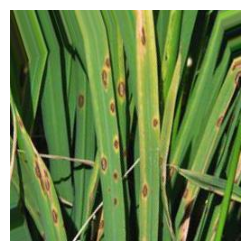


🕒 วันที่และเวลาวินิจฉัย: 22/03/2025 11:20:28
⏳ Processing Time: 5.29 วินาที

--------------------------------
🚨 โรคที่พบ: Brown spot (96.08%) 🚨
--------------------------------

📊 **ผลการวินิจฉัยโรค:**

╒═══════════════════════╤══════════════════════════════════════════════════╤════════════╕
│ โรค                   │ ความแม่นยำ                                        │ เปอร์เซ็นต์   │
╞═══════════════════════╪══════════════════════════════════════════════════╪════════════╡
│ Bacterial leaf blight │                                                  │ 0.02%      │
├───────────────────────┼──────────────────────────────────────────────────┼────────────┤
│ Blast                 │ █                                                │ 3.90%      │
├───────────────────────┼──────────────────────────────────────────────────┼────────────┤
│ Brown spot            │ ████████████████████████████████████████████████ │ 96.08%     │
├───────────────────────┼───────────────────────────────────────────────

Button(button_style='success', description='แสดงข้อมูล', style=ButtonStyle())

Button(button_style='info', description='ค้นหาเพิ่มเติม', style=ButtonStyle())


--------------------------------
🦠 ข้อมูลสำหรับโรค: Brown spot
📌 Cause: เกิดจากเชื้อรา Cochliobolus miyabeanus และอาจเกิดจากการขาดโพแทสเซียมค่ะ
📌 Control: เมื่อพบโรค ควรใช้สารชีวภัณฑ์ เช่น Bacillus ในการควบคุมค่ะ
📌 Solution: เฝ้าระวังช่วงต้นกล้า-ออกรวงและดูแลธาตุอาหารให้เหมาะสมค่ะ
🔎 ค้นหาข้อมูลเพิ่มเติม: https://www.google.com/search?q=Brown+spot


In [ ]:
display(main_panel)